In [1565]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.optimize import minimize

df = pd.read_csv("./Clean/clean-huf-spy-6.csv")
df = df.drop(columns=['Unnamed: 0'])
df.set_index('Dátum', inplace=True)
df = df[::-1]
df = df[df.index >= '2018-03-09']
annual_risk_free_rate = 0.055
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

benchmark = 'S&P 500'
# benchmark = 'USDHUF=X'
# interesting = ['Citadella_Származtatott_Relative_Return', 'Erste_Stock_Hungary_Indexkövető_Részvény_A_Relative_Return',
#                'SP500_Relative_Return', 'HOLD_Nemzetközi_Relative_Return', 'OTP_Supra_Relative_Return', 'HOLD_Columbus_Relative_Return']
# Create a dictionary to rename the columns to something simpler

rename_dict = {
    'Citadella_Származtatott': 'Citadella',
    'Erste_Stock_Hungary_Indexkövető_Részvény_A': 'Erste Indexkövető',
    'Generali_Arany_Oroszlán_ESG': 'Generali ESG',
    'HOLD_Columbus': 'HOLD Columbus',
    'HOLD_Nemzetközi': 'HOLD Nemzetközi',
    'HOLD_VM_Abszolút_Származtatott_Befektetési': 'HOLD Abszolút',
    'MBH_Fejlett_Piaci_Részvény': 'MBH Fejlett Piaci',
    'OTP_Klímaváltozás_13030': 'OTP Klímaváltozás',
    'OTP_Supra': 'OTP Supra',
    'VIG_Opportunity_Fejlett_Piaci_Részvény': 'VIG Opportunity',
    'Accorde_Abacus_Alap': 'Accorde Abacus',
    'Accorde_Prizma_Alap': 'Accorde Prizma',
    'HOLD_Orion': 'HOLD Orion',
    'OTP Föld Kincsei Árupiaci Alapok Alapja HUF': 'OTP Föld Kincsei',
    'Platina Delta Származtatott Befektetési Alap A':'Platina Delta',
    'Raiffeisen Részvény Alap':'Raiffeisen Részvény',
    'Takarék Származtatott Befektetési Alap': 'Gránit Takarék',
    'TakarékApolloSzármaztatottRészvény': 'Gránit Apollo',
    'Erste Duett Nyíltvégű Alapok Alapja': 'Erste Duett',
    'SPY': 'S&P 500',
}

df_relative_returns = df.copy()
relative_return_columns = []
for column in df_relative_returns.columns:
    new_column = column + '_'
    df_relative_returns[column] = df_relative_returns[column] / df_relative_returns[column].iloc[0]
    
df=df_relative_returns
# df=df_relative_returns
interesting = ['Citadella', 'Gránit Apollo','HOLD Columbus', 'HOLD Orion', 'Platina Delta', 'Accorde Prizma', 'OTP Supra', 'Erste Duett', benchmark ]

df = df.rename(columns=rename_dict)
df = df[interesting]
daily_returns = df.pct_change().dropna()


In [1566]:
df

,Citadella,Gránit Apollo,HOLD Columbus,HOLD Orion,Platina Delta,Accorde Prizma,OTP Supra,Erste Duett,S&P 500
Dátum,,,,,,,,,
2018-03-09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-03-12,0.999769,1.001650,1.002696,0.999920,1.002337,1.001205,1.001345,1.000055,0.998141
2018-03-13,0.999737,0.993494,1.003100,0.999893,0.997683,1.000461,0.998542,1.000110,0.990017
2018-03-14,0.999947,0.988882,1.006085,0.999866,0.997159,1.000750,0.997456,1.000110,0.980102
2018-03-19,0.999093,0.982259,1.015453,0.999732,0.989766,1.000947,0.992976,1.000220,0.973219
...,...,...,...,...,...,...,...,...,...
2024-08-08,1.561106,1.919798,1.957978,2.087016,2.698453,1.625783,0.968747,1.368453,3.041900
2024-08-09,1.562690,1.923306,1.951828,2.081122,2.702275,1.627478,0.969226,1.368618,3.045798
2024-08-12,1.570898,1.925606,1.965931,2.097733,2.711484,1.630228,0.972550,1.369167,3.034054


In [1567]:
fee_structure = {
    "Gránit Apollo": {
        "entry_fee_percent": 3.0,
        "exit_fee_percent": 3.0,
        "management_fee_percent": 1.97
    },
    "Erste Indexkövető": {
        "entry_fee_percent": 2.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 0.99,
        "portfolio_transaction_fee_percent": 0.26
    },
    "Generali ESG": {
        "entry_fee_percent": 3.0,
        "exit_fee_percent": 1.5,
        "management_fee_percent": 1.95,
        "transaction_fee_percent": 0.07,
        "performance_fee_percent": 0.0
    },
    "MBH Fejlett Piaci": {
        "entry_fee_percent": 2.22,
        "exit_fee_percent": 0.1,
        "management_fee_percent": 2.24,
        "transaction_fee_percent": 0.1,
        "performance_fee_percent": 0.0
    },
    "OTP Klímaváltozás": {
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 5.0,
        "management_fee_percent": 2.14,
        "transaction_fee_percent": 0.3,
        "performance_fee_percent": 1.23
    },
    "OTP Supra": {
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 5.0,
        "management_fee_percent": 2.21,
        "transaction_fee_percent": 0.84,
        "performance_fee_percent": 1.02
    },
    "HOLD Columbus": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.19,
        "transaction_fee_percent": 0.12,
        "performance_fee_percent": 0.02
    },
    "HOLD Nemzetközi": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.33,
        "transaction_fee_percent": 0.1,
        "performance_fee_percent": 0.0
    },
    "HOLD Abszolút": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.88,
        "transaction_fee_percent": 0.12,
        "performance_fee_percent": 0.67
    },
    "HOLD Orion": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.20,
        "transaction_fee_percent": 0.22,
        "performance_fee_percent": 0.01,
    },
    "VIG Opportunity": {  # bad
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 3.5,
        "management_fee_percent": 1.92,
        "transaction_fee_percent": 0.11,
        "performance_fee_percent": 0.01,
    },
    "Accorde Prizma": {
        "entry_fee_percent": 1.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.09,
        "transaction_fee_percent": 0.0002,
        "performance_fee_percent": 1.59,
    },
    "Platina Delta": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 0.31,
        "transaction_fee_percent": 1.11,
        "performance_fee_percent": 0.19,
    },
    "Citadella": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.88,
        "transaction_fee_percent": 0.08,
        "performance_fee_percent": 1.55,
    },
     "Erste Duett": {
        "entry_fee_percent": 0.5,  # Entry fee of 0.5%
        "exit_fee_percent": 0.0,  # No exit fee
        "management_fee_percent": 0.72,  # Management fee for 6 months projected at 0.72%
        "transaction_fee_percent": 0.02,  # Transaction fee for 6 months projected at 0.02%
        "performance_fee_percent": 0.0  # No performance fee
    }
}


In [1568]:
# good_secus = list(fee_structure.keys()) + [benchmark]
# df = df[good_secus]
# daily_returns = daily_returns[good_secus]

In [1569]:
df['Citadella']

Dátum
2018-03-09    1.000000
2018-03-12    0.999769
2018-03-13    0.999737
2018-03-14    0.999947
2018-03-19    0.999093
                ...   
2024-08-08    1.561106
2024-08-09    1.562690
2024-08-12    1.570898
2024-08-13    1.565224
2024-08-14    1.567576
Name: Citadella, Length: 1544, dtype: float64

In [1570]:
def apply_fees(df_returns, security_name):
    # Retrieve fees for the given security
    fees = fee_structure.get(security_name, None)
    if fees is None:
        raise ValueError(f"Fee structure for {security_name} not found.")

    # Apply entry transaction fee at the start
    entry_fee_percent = max(fees['entry_fee_percent'], fees.get('transaction_fee_percent',0)) / 100
    df_returns.iloc[0] -= entry_fee_percent
    print(f"Entry fee applied on {df_returns.index[0]}: {entry_fee_percent * 100}%")
    
    # Track the end of each year
    last_year = pd.to_datetime(df_returns.index[0], format='%Y-%m-%d').year
    
    for i in range(1, len(df_returns)):
        current_year = pd.to_datetime(df_returns.index[i], format='%Y-%m-%d').year
        
        # Apply fees only once per year
        if current_year != last_year:
            # Apply management fees
            management_fee_percent = fees['management_fee_percent'] / 100
            df_returns.iloc[i] -= management_fee_percent
            print(f"Management fee applied on {df_returns.index[i]}: {management_fee_percent * 100}%")
            
            # Apply performance fee if it exists and if the return is positive
            if 'performance_fee_percent' in fees and fees['performance_fee_percent'] > 0:
                performance_fee_percent = fees['performance_fee_percent'] / 100
                df_returns.iloc[i] -= performance_fee_percent
                print(f"Performance fee applied on {df_returns.index[i]}: {performance_fee_percent * 100}% of excess return")
            
            last_year = current_year
    
    # Apply exit transaction fee at the end
    exit_fee_percent = max(fees['exit_fee_percent'], fees.get('transaction_fee_percent',0))/ 100
    df_returns.iloc[-1] -= exit_fee_percent
    print(f"Exit fee applied on {df_returns.index[-1]}: {exit_fee_percent * 100}%")
    
    return df_returns

# Applying the function to the relative time series with the fees of Citadella
for col in daily_returns.columns:
    print(col)
    if col in fee_structure:
        print(col)
        daily_returns[col] = apply_fees(daily_returns[col], security_name=col)
df_fee = (daily_returns+1).cumprod()



Citadella
Citadella
Entry fee applied on 2018-03-12: 0.08%
Management fee applied on 2019-01-02: 1.8799999999999997%
Performance fee applied on 2019-01-02: 1.55% of excess return
Management fee applied on 2020-01-02: 1.8799999999999997%
Performance fee applied on 2020-01-02: 1.55% of excess return
Management fee applied on 2021-01-04: 1.8799999999999997%
Performance fee applied on 2021-01-04: 1.55% of excess return
Management fee applied on 2022-01-03: 1.8799999999999997%
Performance fee applied on 2022-01-03: 1.55% of excess return
Management fee applied on 2023-01-03: 1.8799999999999997%
Performance fee applied on 2023-01-03: 1.55% of excess return
Management fee applied on 2024-01-02: 1.8799999999999997%
Performance fee applied on 2024-01-02: 1.55% of excess return
Exit fee applied on 2024-08-14: 0.08%
Gránit Apollo
Gránit Apollo
Entry fee applied on 2018-03-12: 3.0%
Management fee applied on 2019-01-02: 1.97%
Management fee applied on 2020-01-02: 1.97%
Management fee applied on 202

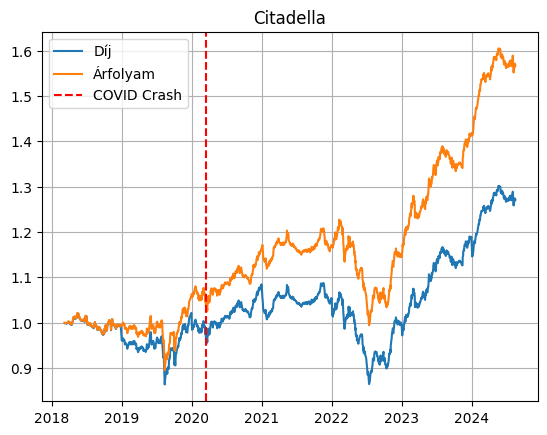

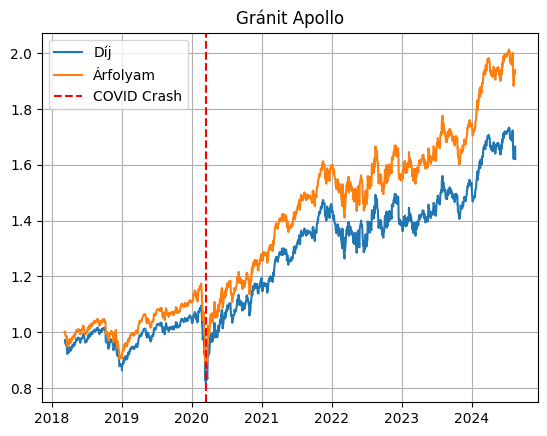

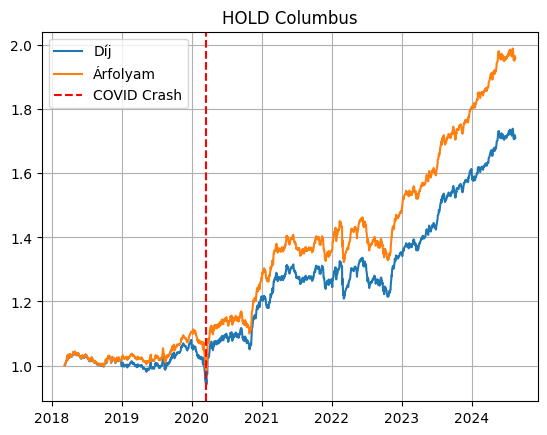

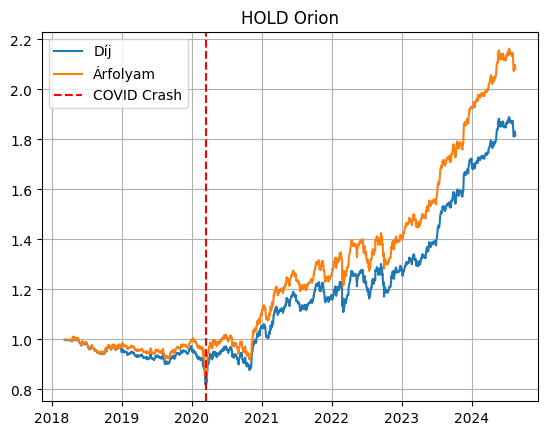

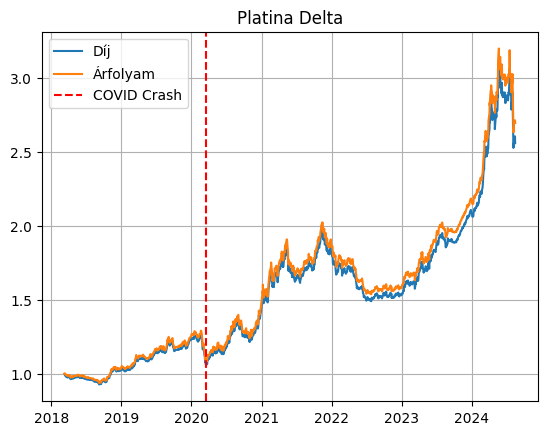

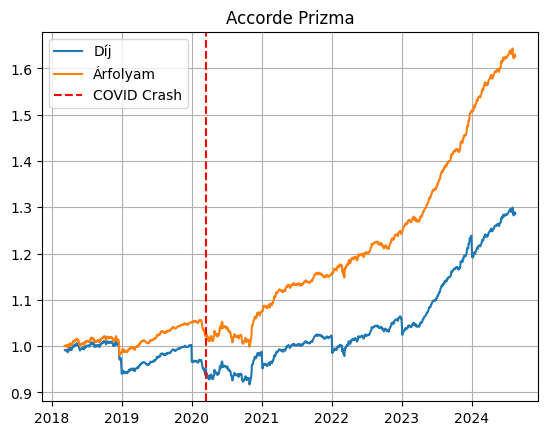

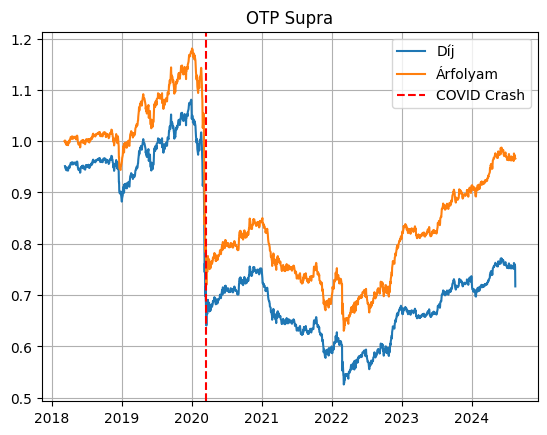

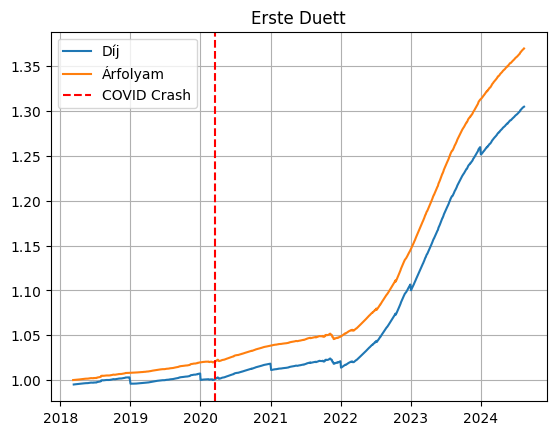

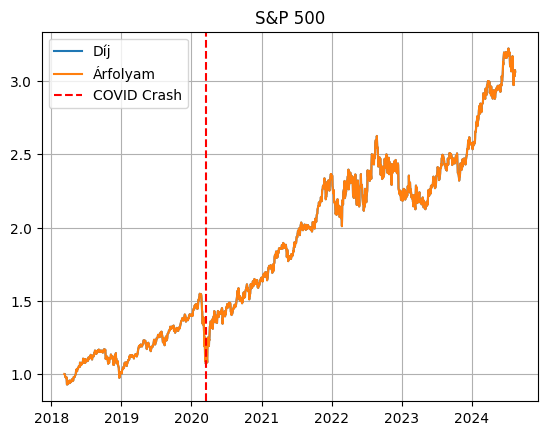

In [1571]:
for col in df_fee.columns:
    plt.plot(pd.to_datetime(df_fee.index), df_fee[col], label='Díj')
    plt.plot(pd.to_datetime(df.index), df[col], label='Árfolyam')

    plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
    plt.title(col)
    # plt.xlabel(x_label)
    plt.legend()
    # plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

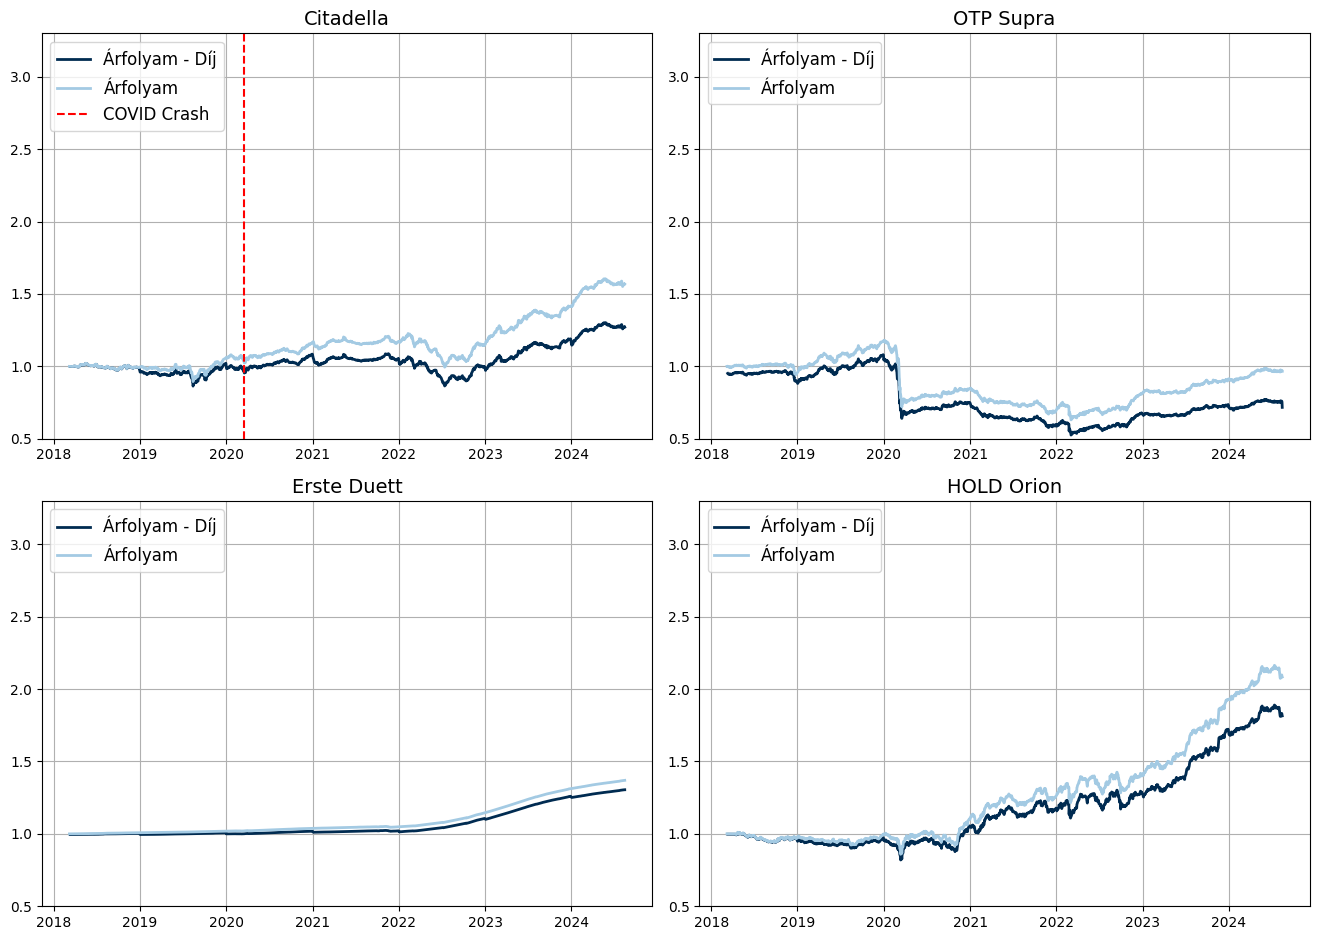

In [1572]:
colors = {
    "Blue-20%": "#D1E4F1",
    "Blue-40%": "#A3CAE3",
    "Blue-80%": "#4695C8",
    "Blue": "#187ABA",
    "Navy-20%": "#CCD5DC",
    "Navy-40%": "#99AAB9",
    "Navy-80%": "#335574",
    "Navy": "#002B51"
}
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
for i, col in enumerate(['Citadella', 'OTP Supra', 'Erste Duett', 'HOLD Orion']):
    axs[i].plot(pd.to_datetime(df_fee.index), df_fee[col], label='Árfolyam - Díj', color=colors["Navy"], linestyle='-', linewidth=2)
    axs[i].plot(pd.to_datetime(df.index), df[col], label='Árfolyam', color=colors["Blue-40%"], linestyle='-', linewidth=2)
    axs[i].set_title(col, fontsize=14)
    if col == "Citadella":
        axs[i].axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')

    axs[i].legend(loc='upper left', fontsize=12)

    # Fix the y-axis resolution (optional: customize as needed)
    axs[i].set_ylim([0.5, 3.3])
    axs[i].grid(True)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('../../../static/Befalapok/dijak.svg', format='svg')
plt.show()


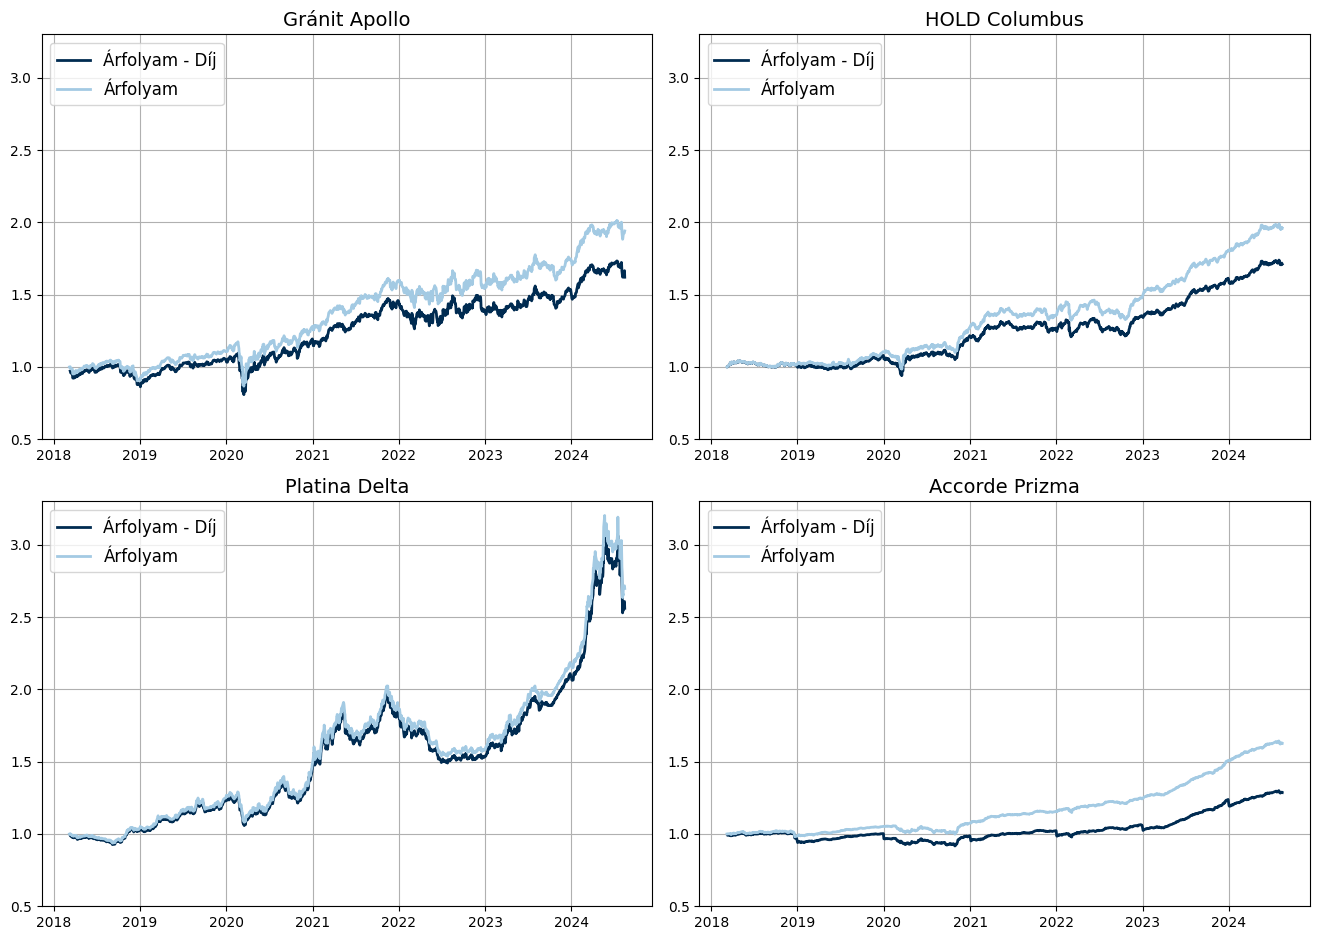

In [1573]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, col in enumerate(['Gránit Apollo','HOLD Columbus',  'Platina Delta', 'Accorde Prizma', ]):
    axs[i].plot(pd.to_datetime(df_fee.index), df_fee[col], label='Árfolyam - Díj', color=colors["Navy"], linestyle='-', linewidth=2)
    axs[i].plot(pd.to_datetime(df.index), df[col], label='Árfolyam', color=colors["Blue-40%"], linestyle='-', linewidth=2)
    axs[i].set_title(col, fontsize=14)
    axs[i].legend(loc='upper left', fontsize=12)
    
    # Fix the y-axis resolution (optional: customize as needed)
    axs[i].set_ylim([0.5, 3.3])
    axs[i].grid(True)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('../../../static/Befalapok/dijak_2.svg', format='svg')
plt.show()

In [1574]:
df = df_fee
daily_returns = df.pct_change().dropna()


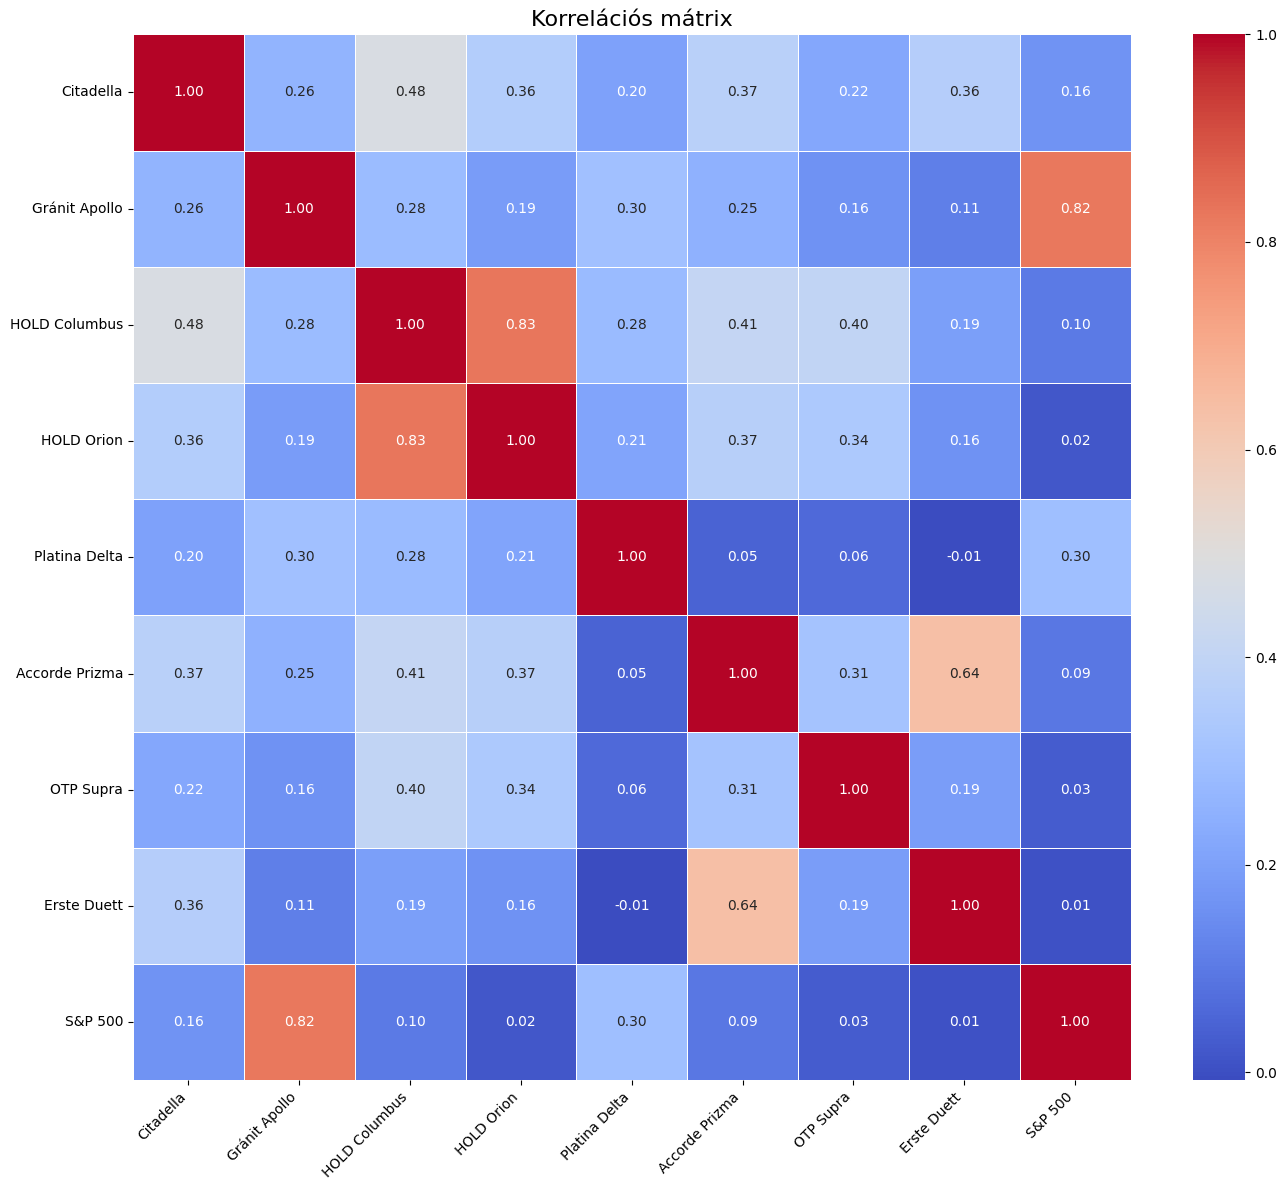

In [1575]:
correlation_matrix = daily_returns.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korrelációs mátrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../../static/Befalapok/korrelacio.svg', format='svg')
plt.show()

In [1576]:
correlation_matrix

,Citadella,Gránit Apollo,HOLD Columbus,HOLD Orion,Platina Delta,Accorde Prizma,OTP Supra,Erste Duett,S&P 500
Citadella,1.000000,0.257596,0.477981,0.356531,0.203117,0.373926,0.218074,0.360395,0.164303
Gránit Apollo,0.257596,1.000000,0.284541,0.189064,0.301577,0.250438,0.161072,0.112876,0.823802
HOLD Columbus,0.477981,0.284541,1.000000,0.830391,0.280384,0.408572,0.399129,0.193937,0.099094
HOLD Orion,0.356531,0.189064,0.830391,1.000000,0.212549,0.368298,0.337987,0.160871,0.016206
Platina Delta,0.203117,0.301577,0.280384,0.212549,1.000000,0.047020,0.061113,-0.007625,0.295640
Accorde Prizma,0.373926,0.250438,0.408572,0.368298,0.047020,1.000000,0.311959,0.640404,0.091731
OTP Supra,0.218074,0.161072,0.399129,0.337987,0.061113,0.311959,1.000000,0.192835,0.028080
Erste Duett,0.360395,0.112876,0.193937,0.160871,-0.007625,0.640404,0.192835,1.000000,0.006084
S&P 500,0.164303,0.823802,0.099094,0.016206,0.295640,0.091731,0.028080,0.006084,1.000000


In [1577]:
# spy_correlated = ['S&P 500','Generali ESG', 'HOLD Nemzetközi', 'MBH Fejlett Piaci', 'OTP Klímaváltozás', 'Gránit Apollo','VIG Opportunity'  ]
# correlation_matrix = daily_returns[spy_correlated].corr()
# plt.figure(figsize=(14, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation Matrix Heatmap', fontsize=16)
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

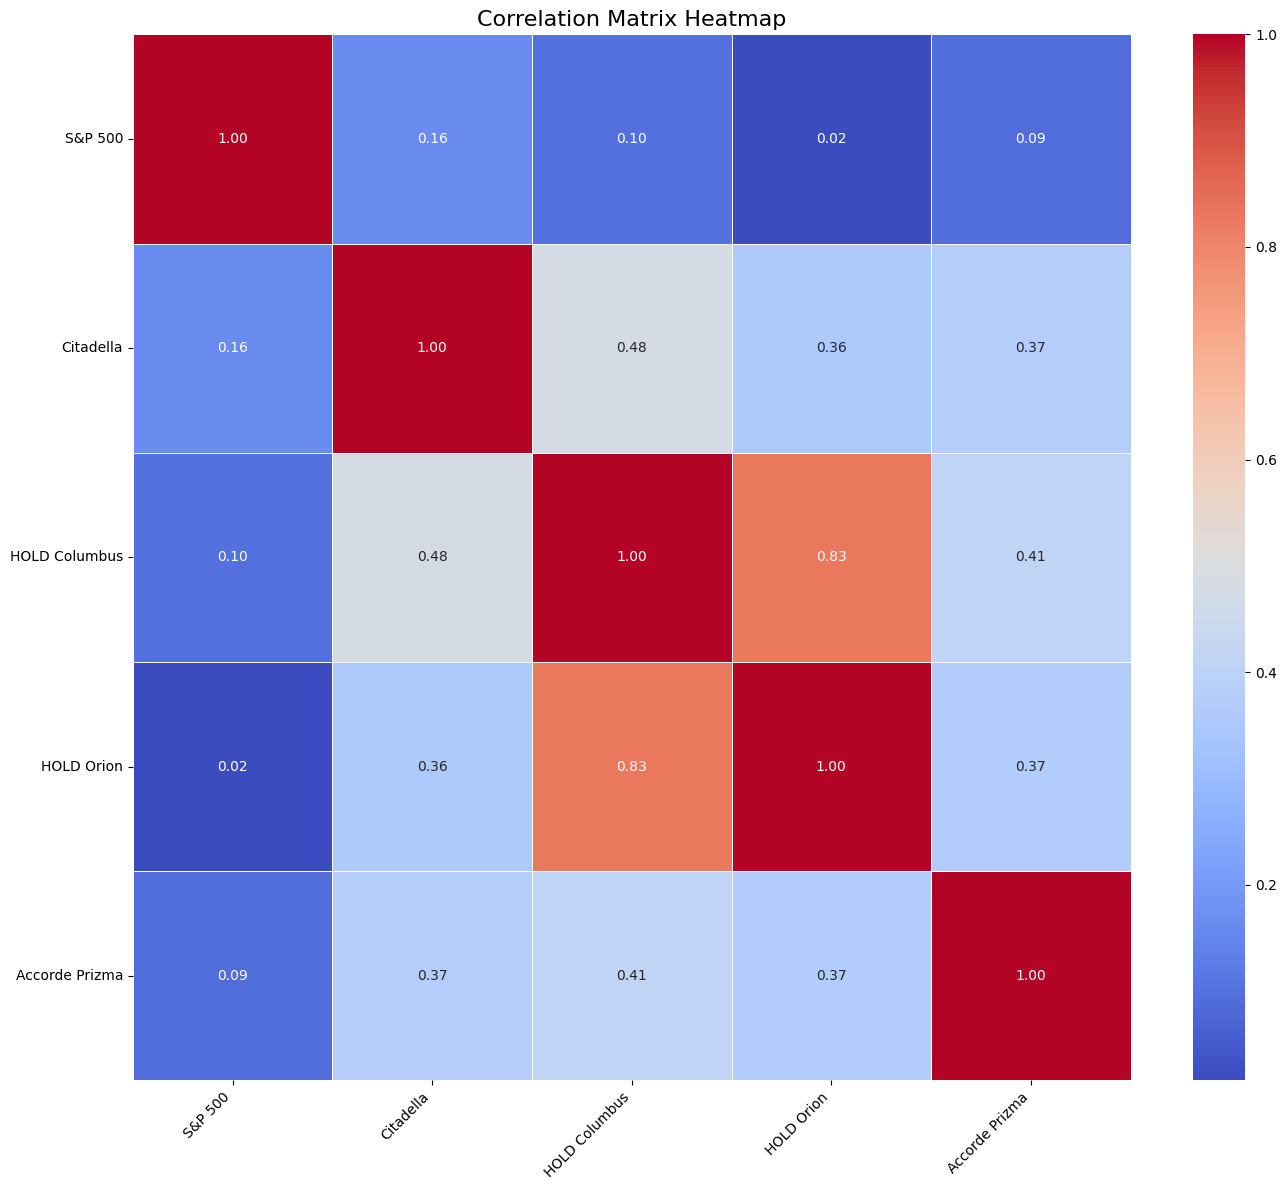

In [1578]:
spy_correlated = ['S&P 500','Citadella', 'HOLD Columbus','HOLD Orion','Accorde Prizma', ]
correlation_matrix = daily_returns[spy_correlated].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [1579]:
import matplotlib.cm as cm

def draw_decreasing_barchart(data, title, x_label, y_label, path=None):
    # Sort data in descending order
    data = data.sort_values(ascending=False)
    
    # Determine the number of bars
    num_bars = len(data)

    # Generate colors using the Blues colormap
    blues_colormap = cm.Blues(np.linspace(0.9, 0.2, num_bars))  # Adjust the range as needed for color depth

    # Assign colors to each bar, highlight 'S&P 500' in red
    bar_colors = ['red' if idx == 'S&P 500' else blues_colormap[i] for i, idx in enumerate(data.index)]
    
    # Create the bar chart
    plt.figure(figsize=(14, 8))
    bars = data.plot(kind='bar', color=bar_colors, edgecolor='black')
    
    # Rotate x labels for better spacing
    plt.xticks(rotation=45, ha='right', fontsize=12, )
    
    # Apply titles and labels with improved styling
    plt.title(title, fontsize=20, pad=20)  # Navy with padding
    plt.xlabel(x_label, fontsize=16, labelpad=10)  # Navy-80% with padding
    plt.ylabel(y_label, fontsize=16,  labelpad=10)  # Navy-80% with padding
    
    # Set grid and customize its color
    plt.grid(axis='y', linestyle='--', linewidth=0.7, color='#99AAB9')  # Navy-40%
    
    # Remove the box around the plot for a cleaner look
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['left'].set_color('#335574')  # Navy-80%
    # plt.gca().spines['bottom'].set_color('#335574')  # Navy-80%
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    if path:
        plt.savefig(path, format='svg')
    else:
        # Show the plot
        plt.show()
    
def draw_linechart(data, title, x_label, y_label, benchmark='S&P 500', path=None):

    
    plt.figure(figsize=(12, 8))
    
    # Plot each column with varying colors
    num_colors = len(data.columns) - 1

    blues_colormap = cm.Blues(np.linspace(0.3, 0.8, num_colors))  # Adjust the range as needed for color depth

    # Plot each column with varying colors
    for i, column in enumerate(data.columns):
        if column == benchmark:
            plt.plot(pd.to_datetime(data.index), data[column], label=column, color='red', linewidth=2.5)
        else:
            plt.plot(pd.to_datetime(data.index), data[column], label=column, color=blues_colormap[i % num_colors], linewidth=2)

    # Add the COVID Crash line
    plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', linewidth=1.5, label='Covid krach')

    # Apply titles and labels with improved styling
    plt.title(title, fontsize=18, )  # Navy
    plt.xlabel(x_label, fontsize=14, )  # Navy-80%
    plt.ylabel(y_label, fontsize=14, )  # Navy-80%
    
    # Display the legend
    plt.legend(loc='upper left', fontsize=12)
    
    # Set grid and customize its color
    plt.grid(True, linestyle='--', linewidth=0.7, color='#99AAB9')  # Navy-40%
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    if path:
        plt.savefig(path, format='svg')
    else:
        # Show the plot
        plt.show()

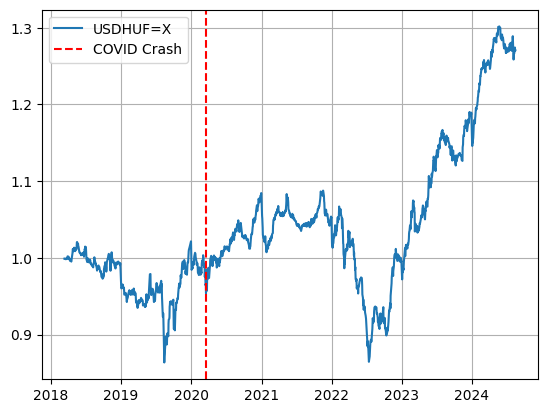

In [1580]:
plt.plot(pd.to_datetime(df.index), df['Citadella'], label=column)

plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
# plt.title(title)
# plt.xlabel(x_label)
plt.legend()
# plt.ylabel(y_label)
plt.grid(True)
plt.show()

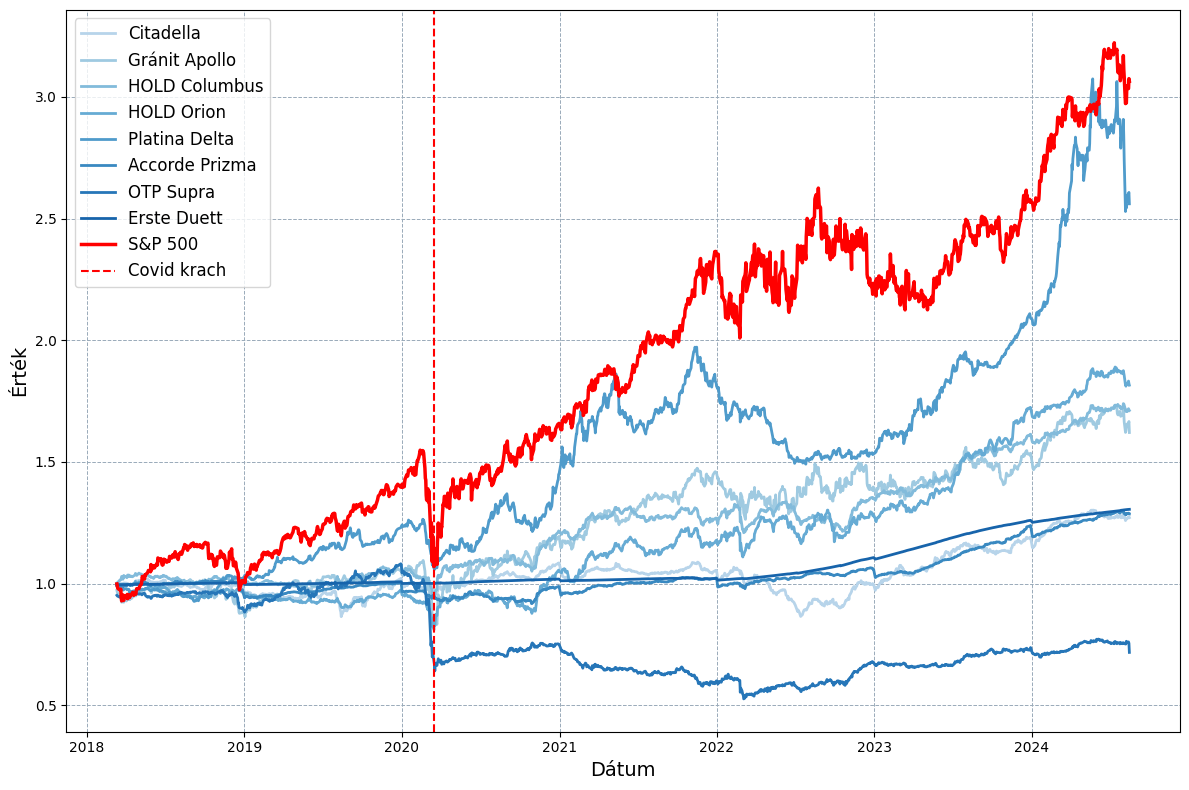

In [1581]:
draw_linechart(df, '', 'Dátum', 'Érték' ,path='../../../static/Befalapok/hozamok.svg' )

In [1582]:
df

,Citadella,Gránit Apollo,HOLD Columbus,HOLD Orion,Platina Delta,Accorde Prizma,OTP Supra,Erste Duett,S&P 500
Dátum,,,,,,,,,
2018-03-12,0.998969,0.971650,1.001496,0.997720,0.991237,0.991205,0.951345,0.995055,0.998141
2018-03-13,0.998937,0.963739,1.001900,0.997693,0.986635,0.990468,0.948682,0.995110,0.990017
2018-03-14,0.999147,0.959265,1.004881,0.997666,0.986116,0.990755,0.947650,0.995110,0.980102
2018-03-19,0.998294,0.952840,1.014238,0.997532,0.978805,0.990950,0.943394,0.995219,0.973219
2018-03-20,0.998823,0.956343,1.013914,0.997506,0.980322,0.991641,0.945740,0.995219,0.971604
...,...,...,...,...,...,...,...,...,...
2024-08-08,1.266240,1.652805,1.711632,1.822523,2.590364,1.285731,0.756902,1.303865,3.041900
2024-08-09,1.267526,1.655825,1.706256,1.817376,2.594034,1.287072,0.757276,1.304022,3.045798
2024-08-12,1.274183,1.657805,1.718584,1.831882,2.602874,1.289246,0.759873,1.304545,3.034054


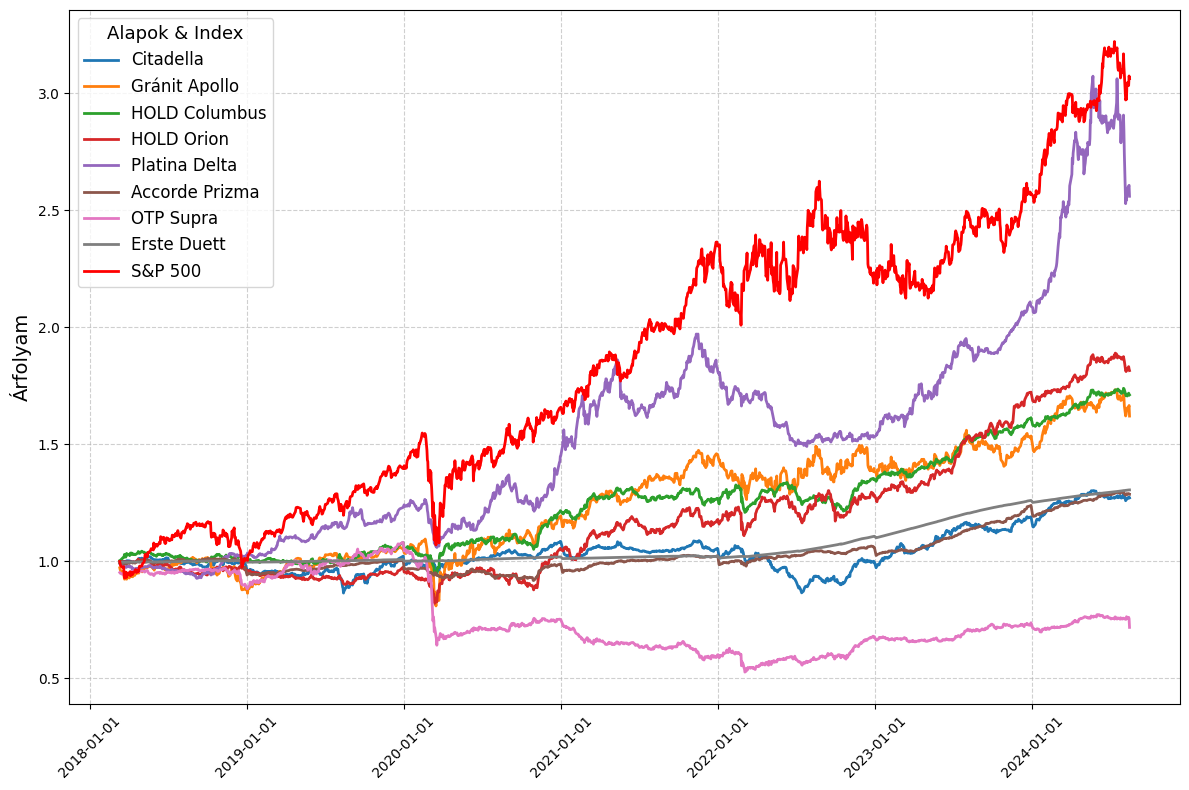

In [1583]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already defined as per the provided data structure
# Convert 'Dátum' index to datetime format if not already
df.index = pd.to_datetime(df.index)

plt.figure(figsize=(12, 8))

# Plot each column with specific styling for 'S&P 500'
for column in df.columns:
    if column == 'S&P 500':
        plt.plot(df.index, df[column], linestyle='-', linewidth=2, color='red', label=column)
    else:
        plt.plot(df.index, df[column], linestyle='-', linewidth=2, label=column)

# Adding title and labels
plt.title('', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Árfolyam', fontsize=14)

# Customize the grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Alapok & Index', fontsize=12, title_fontsize='13')

# Reduce the number of x-axis ticks to avoid clutter
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator(maxticks=10))

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../../../static/Befalapok/hozamok.svg', format='svg')

plt.show()


In [1584]:

plt.figure(figsize=(12, 8))

# Plot each column with varying colors
num_colors = len(data.columns) - 1

blues_colormap = cm.Blues(np.linspace(0.3, 0.8, num_colors))  # Adjust the range as needed for color depth

# Plot each column with varying colors
for i, column in enumerate(data.columns):
    if column == benchmark:
        plt.plot(pd.to_datetime(data.index), data[column], label=column, color='red', linewidth=2.5)
    else:
        plt.plot(pd.to_datetime(data.index), data[column], label=column, color=blues_colormap[i % num_colors], linewidth=2)

# Add the COVID Crash line
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', linewidth=1.5, label='Covid krach')

# Apply titles and labels with improved styling
plt.title(title, fontsize=18, )  # Navy
plt.xlabel(x_label, fontsize=14, )  # Navy-80%
plt.ylabel(y_label, fontsize=14, )  # Navy-80%

# Display the legend
plt.legend(loc='upper left', fontsize=12)

# Set grid and customize its color
plt.grid(True, linestyle='--', linewidth=0.7, color='#99AAB9')  # Navy-40%

# Tight layout for better spacing
plt.tight_layout()

if path:
    plt.savefig(path, format='svg')
else:
    # Show the plot
    plt.show()

NameError: name 'data' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
average_daily_returns = daily_returns.mean()
excess_returns = average_daily_returns - daily_risk_free_rate
std_dev_returns = daily_returns.std()
sharpe_ratios_daily = excess_returns / std_dev_returns
sharpe_ratios_annualized = sharpe_ratios_daily * np.sqrt(252)
sharpe_ratios_df = pd.DataFrame({
    'Average Daily Return': average_daily_returns,
    'Standard Deviation of Returns': std_dev_returns,
    'Daily Sharpe Ratio': sharpe_ratios_daily,
    'Annualized Sharpe Ratio': sharpe_ratios_annualized
})
sharpe_ratios_df

,Average Daily Return,Standard Deviation of Returns,Daily Sharpe Ratio,Annualized Sharpe Ratio
Citadella,0.000169,0.005115,-0.008492,-0.134801
Gránit Apollo,0.000388,0.010554,0.016587,0.263314
HOLD Columbus,0.000361,0.005233,0.028396,0.450771
HOLD Orion,0.000412,0.006969,0.028697,0.455556
Platina Delta,0.000654,0.008701,0.050698,0.804800
Accorde Prizma,0.000173,0.002991,-0.013058,-0.207286
OTP Supra,-0.000147,0.008405,-0.042807,-0.679536
Erste Duett,0.000176,0.000531,-0.068899,-1.093740
S&P 500,0.000835,0.014630,0.042543,0.675345


In [ ]:
(1+daily_returns.mean())**252

Citadella         1.043518
Gránit Apollo     1.102568
HOLD Columbus     1.095246
HOLD Orion        1.109512
Platina Delta     1.178980
Accorde Prizma    1.044669
OTP Supra         0.963562
Erste Duett       1.045316
S&P 500           1.234056
dtype: float64

In [ ]:
daily_returns.std()

Citadella         1.288957
Gránit Apollo     2.659537
HOLD Columbus     1.318809
HOLD Orion        1.756105
Platina Delta     2.192547
Accorde Prizma    0.753794
OTP Supra         2.117950
Erste Duett       0.133869
S&P 500           3.686825
dtype: float64

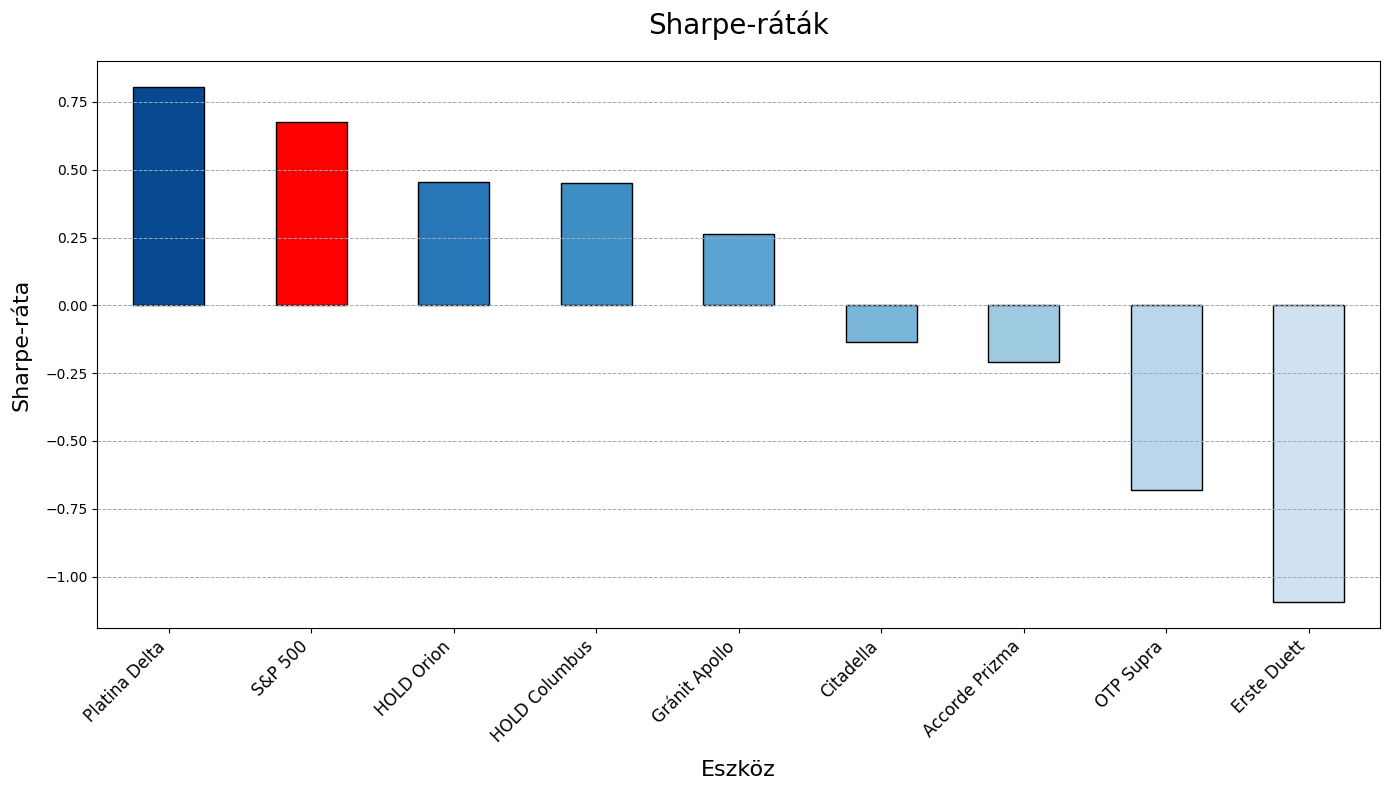

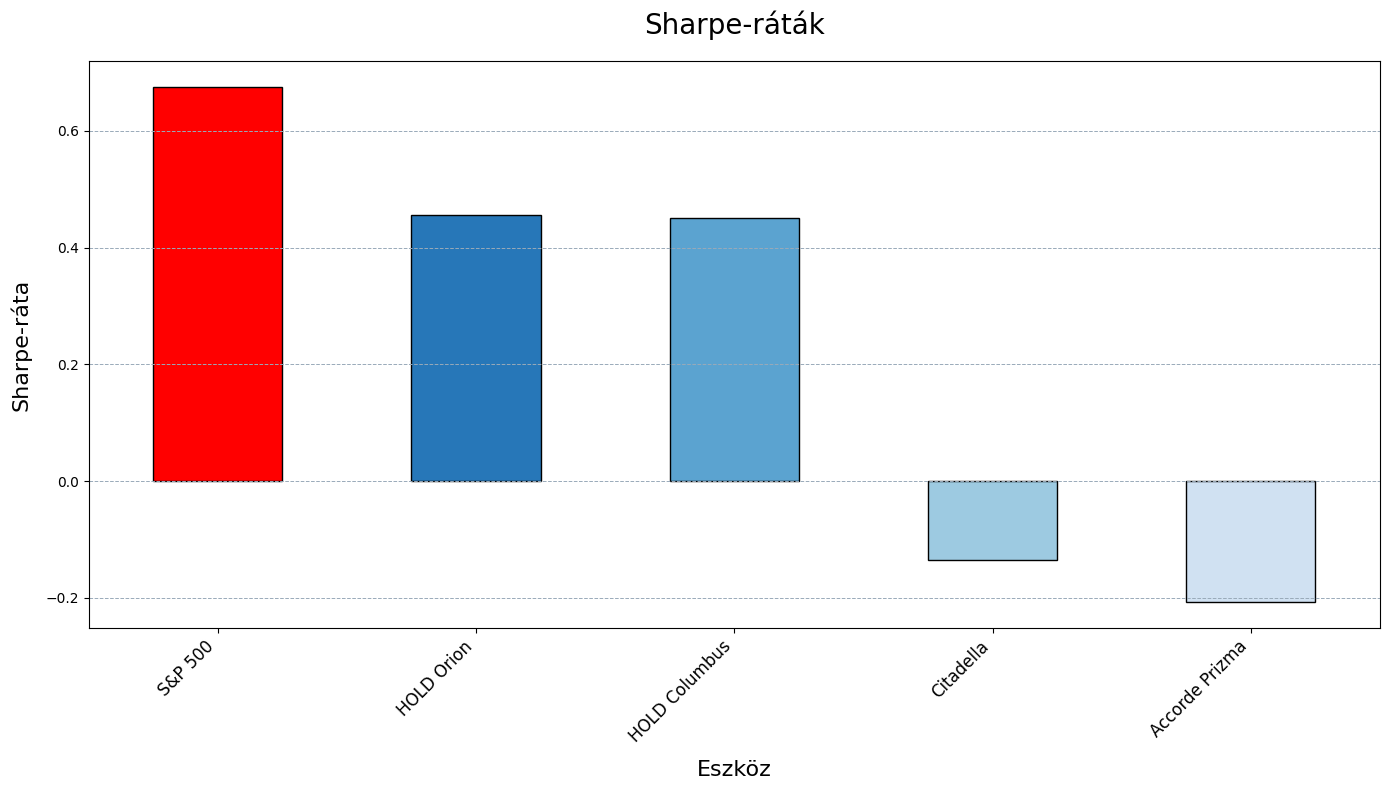

In [ ]:
# sharpe_ratios_df = sharpe_ratios_df[interesting]
# Sort the Sharpesharpe_ratios_df Ratios in descending order for the bar chart
sorted_sharpe_ratios = sharpe_ratios_df['Annualized Sharpe Ratio'].sort_values(ascending=False)
draw_decreasing_barchart(sorted_sharpe_ratios, 'Sharpe-ráták', 'Eszköz', 'Sharpe-ráta',path='../../../static/Befalapok/sharpe.svg' )

draw_decreasing_barchart(sorted_sharpe_ratios[spy_correlated], 'Sharpe-ráták', 'Eszköz', 'Sharpe-ráta')


Sortino Ratios:
 Citadella        -0.163021
Gránit Apollo     0.344611
HOLD Columbus     0.609876
HOLD Orion        0.625126
Platina Delta     1.014630
Accorde Prizma   -0.190045
OTP Supra        -0.703703
Erste Duett      -1.182684
S&P 500           0.887264
dtype: float64
Treynor Ratios:
 Citadella        -0.000756
Gránit Apollo     0.000294
HOLD Columbus     0.004190
HOLD Orion        0.025891
Platina Delta     0.002507
Accorde Prizma   -0.002081
OTP Supra        -0.022289
Erste Duett      -0.165586
S&P 500           0.000622
dtype: float64


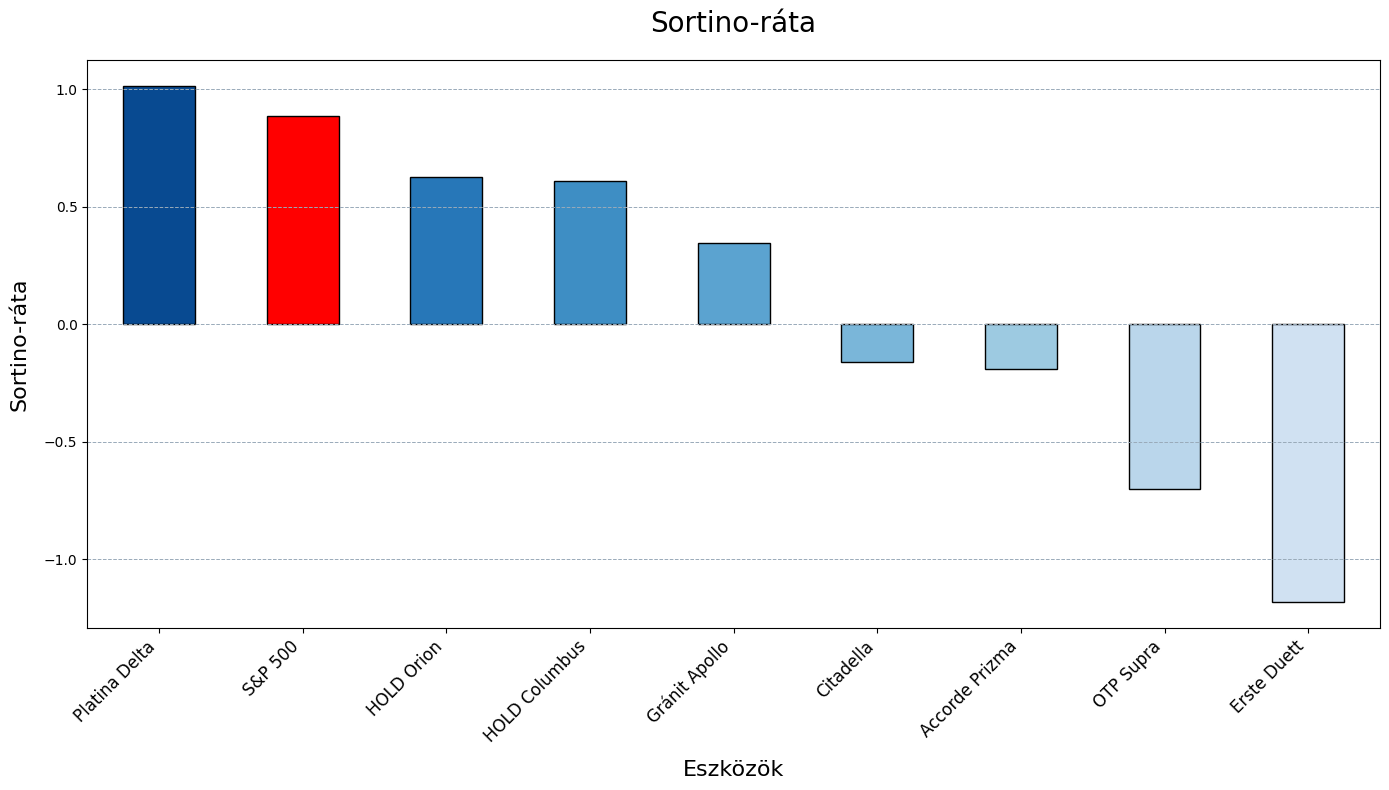

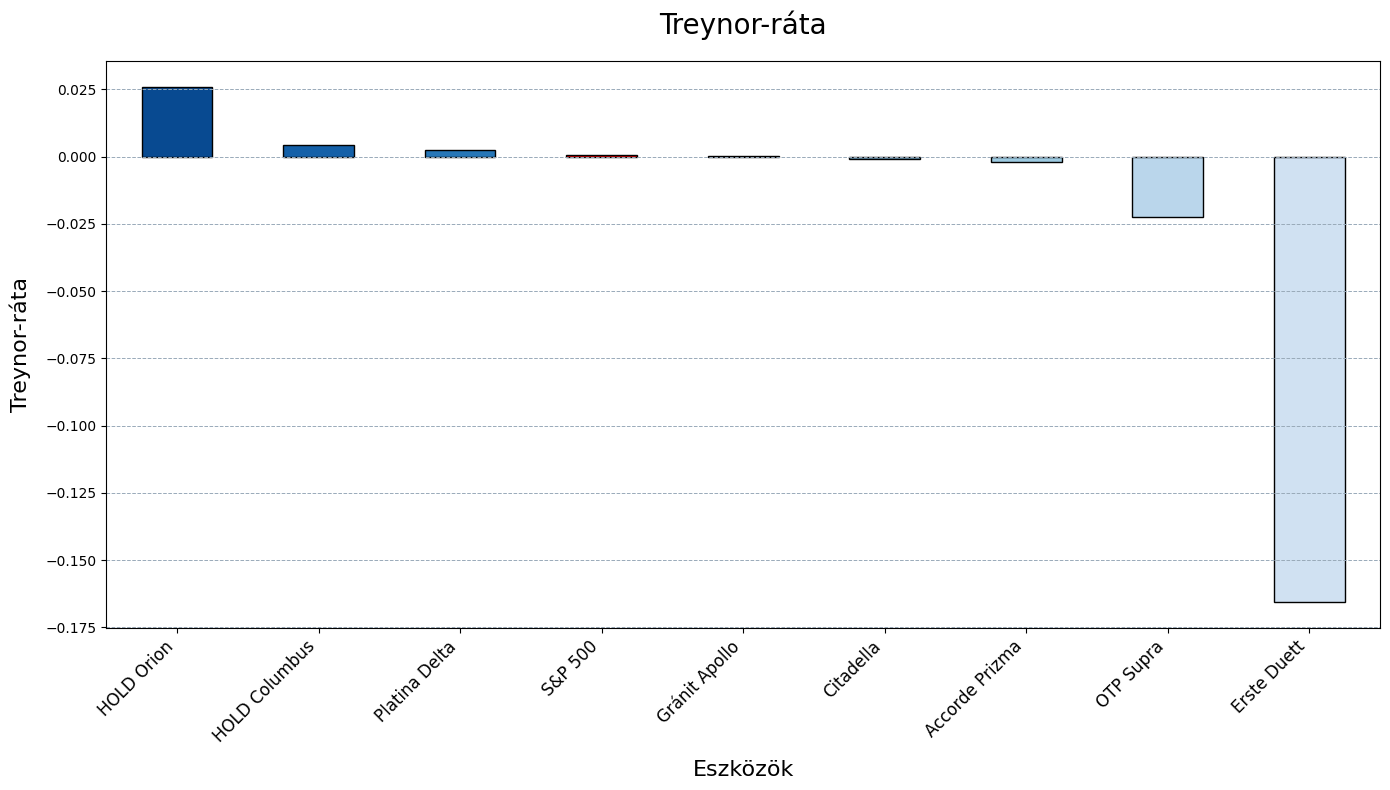

In [ ]:
def sortino_ratio(returns, target=0):
    excess_returns = returns - target
    downside_deviation = np.std(excess_returns[excess_returns < target])
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    sortino_ratio_annualized = sortino_ratio * np.sqrt(252)
    
    return sortino_ratio_annualized
sortino_ratios = daily_returns.apply(sortino_ratio, target=daily_risk_free_rate)
print("Sortino Ratios:\n", sortino_ratios)
draw_decreasing_barchart(sortino_ratios, 'Sortino-ráta', 'Eszközök', 'Sortino-ráta', path='../../../static/Befalapok/sortino.svg')

def treynor_ratio(returns, market_returns, beta, daily_risk_free_rate):
    excess_returns = np.mean(returns) - daily_risk_free_rate
    treynor_ratio = excess_returns / beta
    return treynor_ratio

market_returns = daily_returns[benchmark]
betas = daily_returns.apply(lambda x: np.cov(x, market_returns)[0, 1] / np.var(market_returns))
treynor_ratios = daily_returns.apply(lambda x: treynor_ratio(x, market_returns, betas[x.name], daily_risk_free_rate))
print("Treynor Ratios:\n", treynor_ratios)
draw_decreasing_barchart(treynor_ratios, 'Treynor-ráta', 'Eszközök', 'Treynor-ráta',  path='../../../static/Befalapok/treynor.svg')


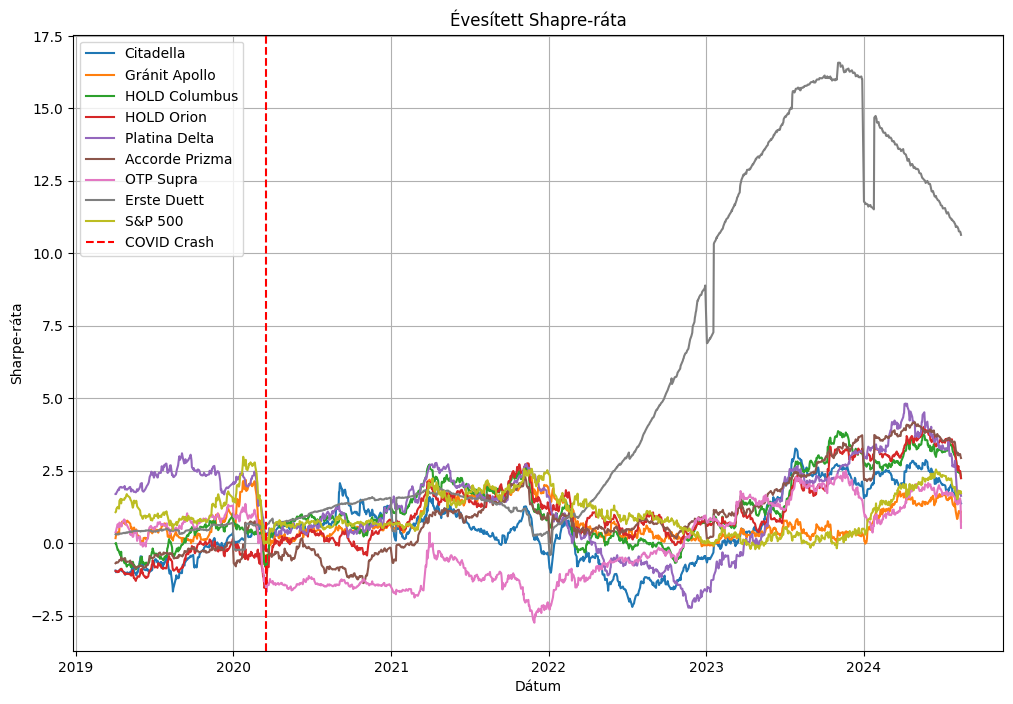

In [ ]:
window_size = 252
rolling_sharpe_ratios = (
    daily_returns.rolling(window=window_size).mean() / 
    daily_returns.rolling(window=window_size).std()
) * np.sqrt(252)
draw_linchart(rolling_sharpe_ratios, 'Évesített Shapre-ráta', 'Dátum', 'Sharpe-ráta')


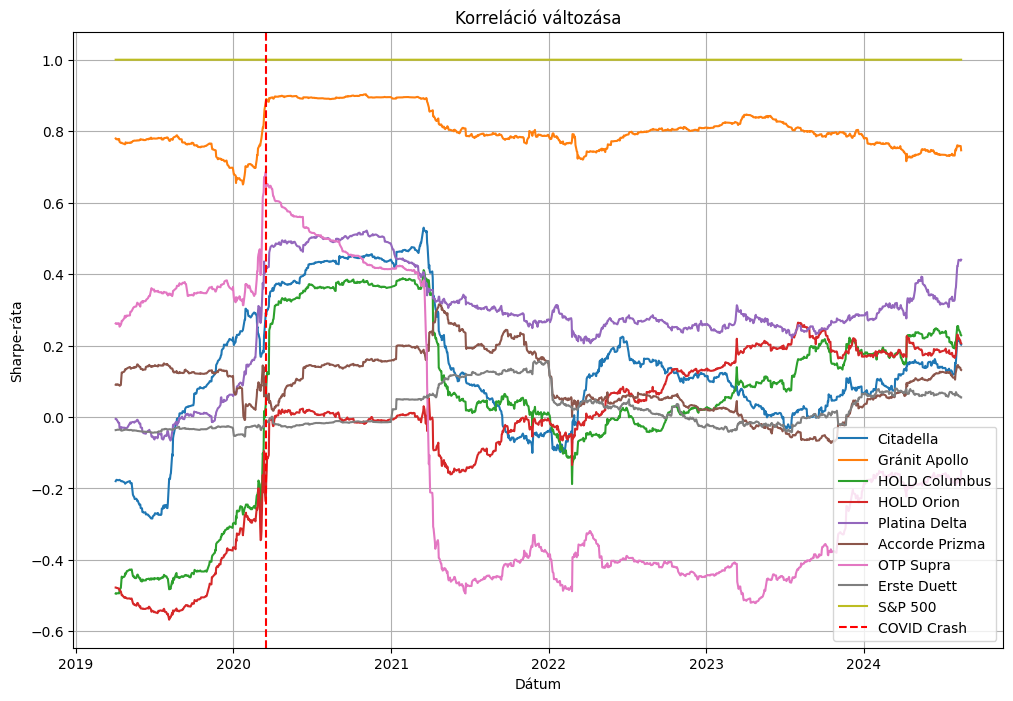

In [ ]:
rolling_correlations = daily_returns.rolling(window=window_size).corr(daily_returns[benchmark])
draw_linchart(rolling_correlations, 'Korreláció változása', 'Dátum', 'Sharpe-ráta')


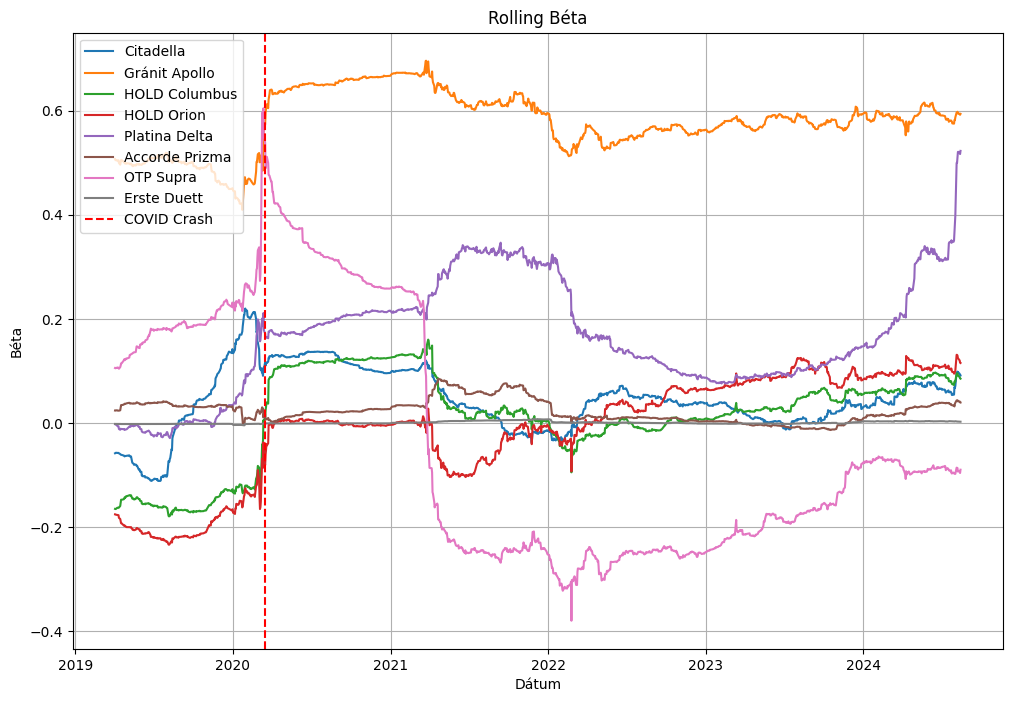

In [ ]:
benchmark_returns = daily_returns[benchmark]
window_size = 252
betas = pd.DataFrame(index=daily_returns.index)
for column in daily_returns.columns:
    if column != benchmark: 
        rolling_covariance = daily_returns[column].rolling(window=window_size).cov(benchmark_returns)
        rolling_variance = benchmark_returns.rolling(window=window_size).var()
        rolling_beta = rolling_covariance / rolling_variance
        betas[column] = rolling_beta    
draw_linchart(betas, 'Rolling Béta', 'Dátum', 'Béta')


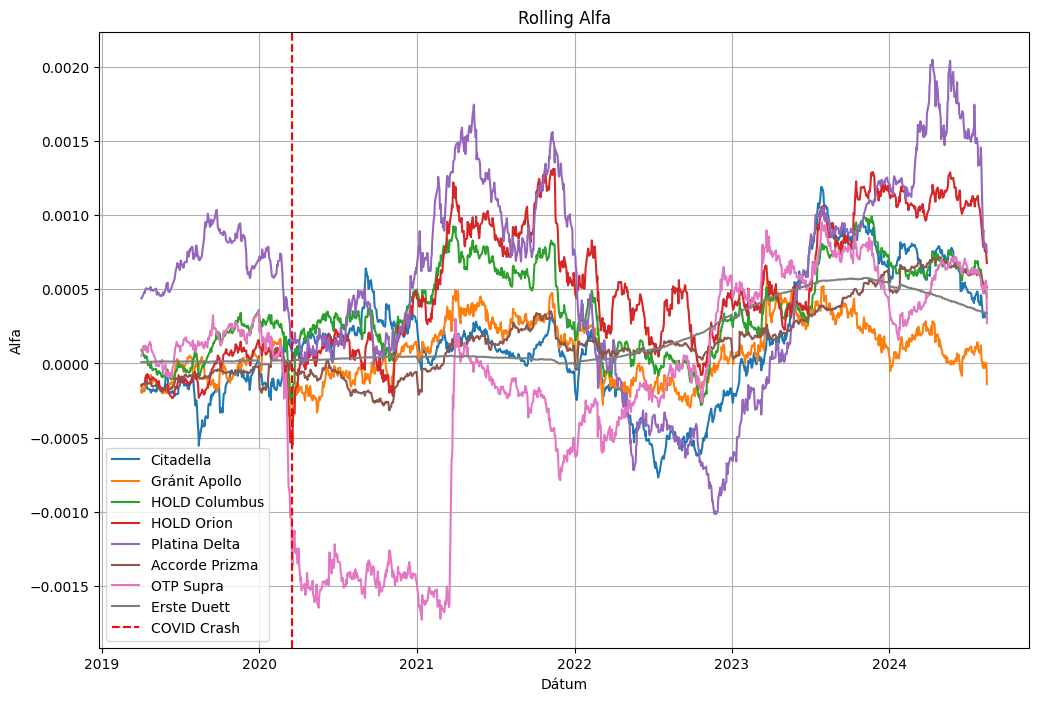

In [ ]:
alphas = pd.DataFrame(index=daily_returns.index)
for column in daily_returns.columns:
    if column != benchmark:  # Skip the benchmark itself
        rolling_covariance = daily_returns[column].rolling(window=window_size).cov(benchmark_returns)
        rolling_variance = benchmark_returns.rolling(window=window_size).var()
        rolling_beta = rolling_covariance / rolling_variance
        expected_returns = rolling_beta * (benchmark_returns.rolling(window=window_size).mean() - daily_risk_free_rate)
        rolling_alpha = daily_returns[column].rolling(window=window_size).mean() - expected_returns
        alphas[column] = rolling_alpha
draw_linchart(alphas, 'Rolling Alfa', 'Dátum', 'Alfa')

Platina Delta     0.000560
HOLD Orion        0.000481
HOLD Columbus     0.000363
Erste Duett       0.000179
Accorde Prizma    0.000146
Citadella         0.000139
Gránit Apollo     0.000082
OTP Supra        -0.000146
dtype: float64


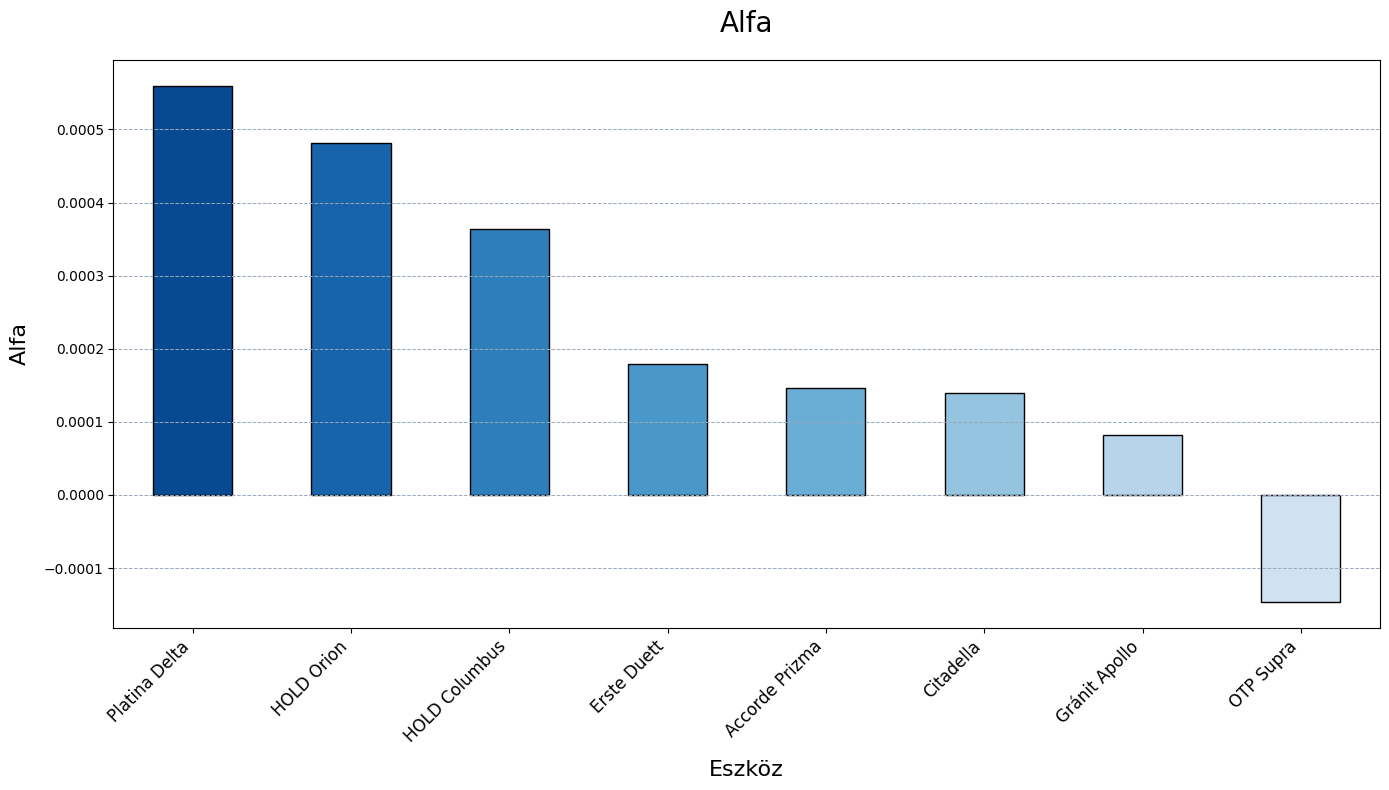

In [ ]:
mean_alphas = alphas.mean()
mean_alphas = mean_alphas.sort_values(ascending=False)
print(mean_alphas)
draw_decreasing_barchart(mean_alphas, 'Alfa', 'Eszköz', 'Alfa')

C:\Users\takat\AppData\Local\Temp\ipykernel_33328\509753409.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(distance_matrix, method='average')


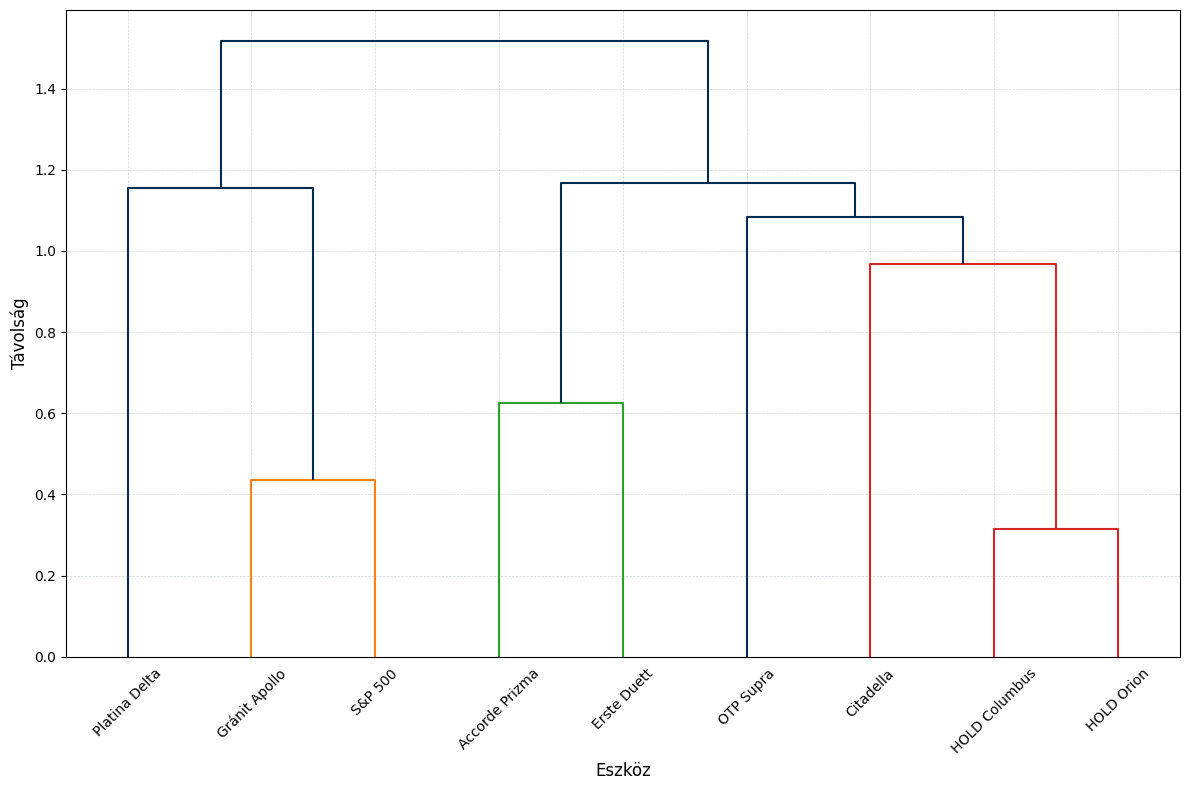

In [ ]:
correlation_matrix = daily_returns.corr()
distance_matrix = 1 - correlation_matrix
linked = sch.linkage(distance_matrix, method='average')

# Set up the plot with improved styling
plt.figure(figsize=(12, 8))

# Dendrogram with custom styling
sch.dendrogram(
    linked,
    labels=correlation_matrix.columns,
    orientation='top',
    color_threshold=None,
    above_threshold_color='#002B51',  # Navy for the main branches
    leaf_rotation=45,
)

# Background and text settings
plt.gcf().set_facecolor('white')  # Background is white
# plt.title('Hierarchikus Klaszterezés Dendrogram (Korr)', fontsize=16, color='black')
plt.xlabel('Eszköz', fontsize=12, color='black')
plt.ylabel('Távolság', fontsize=12, color='black')
plt.xticks(rotation=45, fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Set the grid color and style
plt.grid(color='#CCD5DC', linestyle='--', linewidth=0.5)

# Adjust the layout for better spacing
plt.tight_layout()
plt.savefig('../../../static/Befalapok/dendogram.svg', format='svg')

plt.show()

In [ ]:
# monthly_returns = df.resample('M').last().pct_change().dropna()
# shapiro_test_results_monthly = {}
# x = np.linspace(-0.2, 0.2, 1000)
# plt.figure(figsize=(12, 8))
# for column in monthly_returns.columns:
#     try:
#         returns = monthly_returns[column].dropna()
#         W, p_value = shapiro(returns)
#         shapiro_test_results_monthly[column] = {
#             'W-statistic': W,
#             'p-value': p_value,
#             'is_normal': p_value > 0.05
#         }
#         mu, std = norm.fit(returns)
#         fitted_curve = norm.pdf(x, mu, std)
#         plt.plot(x, fitted_curve, label=f"{column} (p={p_value:.3f})")
#     except Exception as e:
#         shapiro_test_results_monthly[column] = {
#             'W-statistic': None,
#             'p-value': None,
#             'is_normal': False,
#             'error': str(e)
#         }
# plt.title('Fitted Normal Distributions for Each Monthly Return Series', fontsize=16)
# plt.xlabel('Monthly Returns', fontsize=12)
# plt.ylabel('Density', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.xlim(-0.1,0.1)
# plt.show()
# shapiro_test_results_monthly

In [ ]:
# monthly_means = monthly_returns.mean()
# draw_decreasing_barchart(monthly_means, 'Átlagos havi hozamok', 'Eszköz', 'Hozam')

Max Drawdowns:
 Citadella        -0.205072
Gránit Apollo    -0.261444
HOLD Columbus    -0.128872
HOLD Orion       -0.187569
Platina Delta    -0.243984
Accorde Prizma   -0.093234
OTP Supra        -0.513646
Erste Duett      -0.009944
S&P 500          -0.309207
dtype: float64
Calmar Ratios:
 Citadella         0.207737
Gránit Apollo     0.373544
HOLD Columbus     0.706090
HOLD Orion        0.554153
Platina Delta     0.675058
Accorde Prizma    0.468749
OTP Supra        -0.072260
Erste Duett       4.457334
S&P 500           0.680431
dtype: float64
Recovery Times:
 Citadella           7
Gránit Apollo       8
HOLD Columbus      11
HOLD Orion          8
Platina Delta       9
Accorde Prizma     10
OTP Supra           6
Erste Duett       185
S&P 500             9
dtype: int32


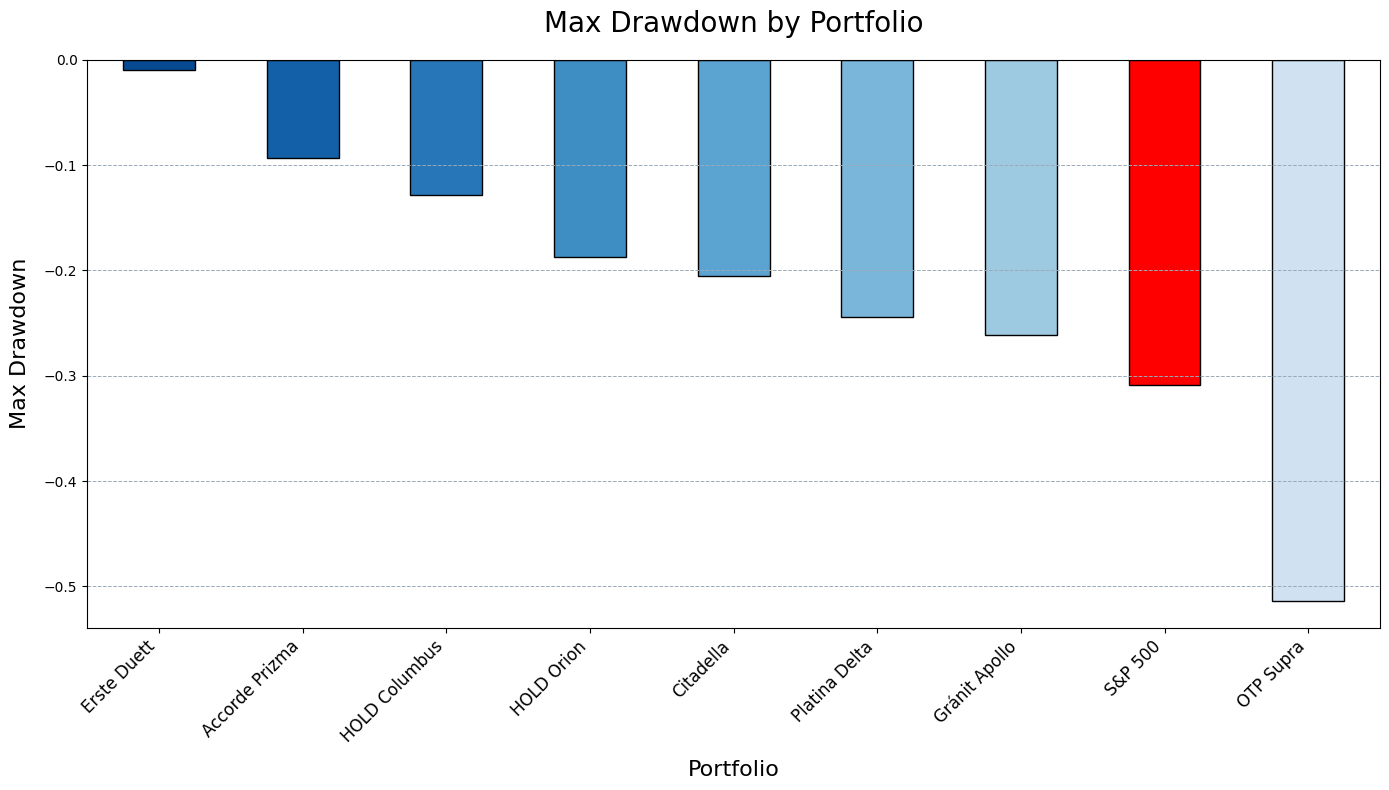

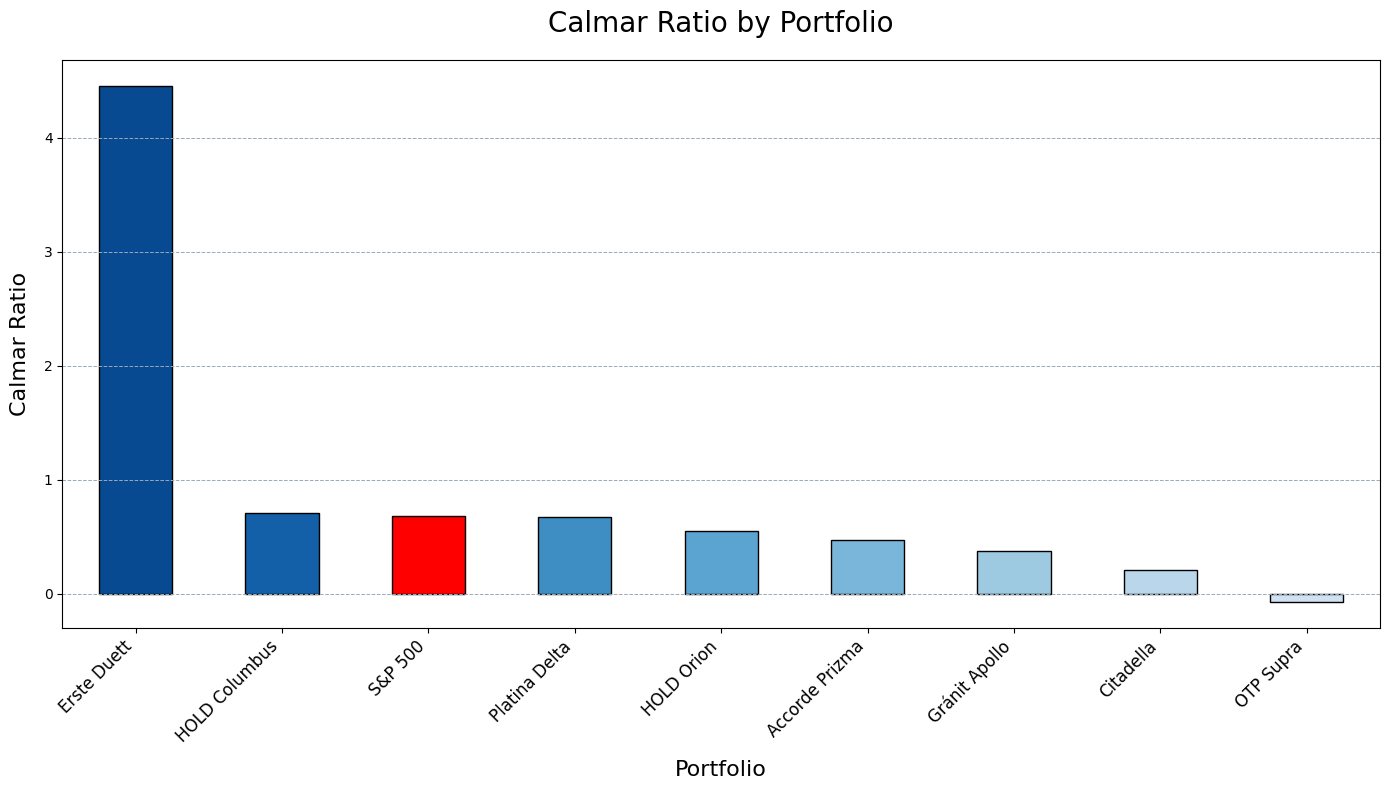

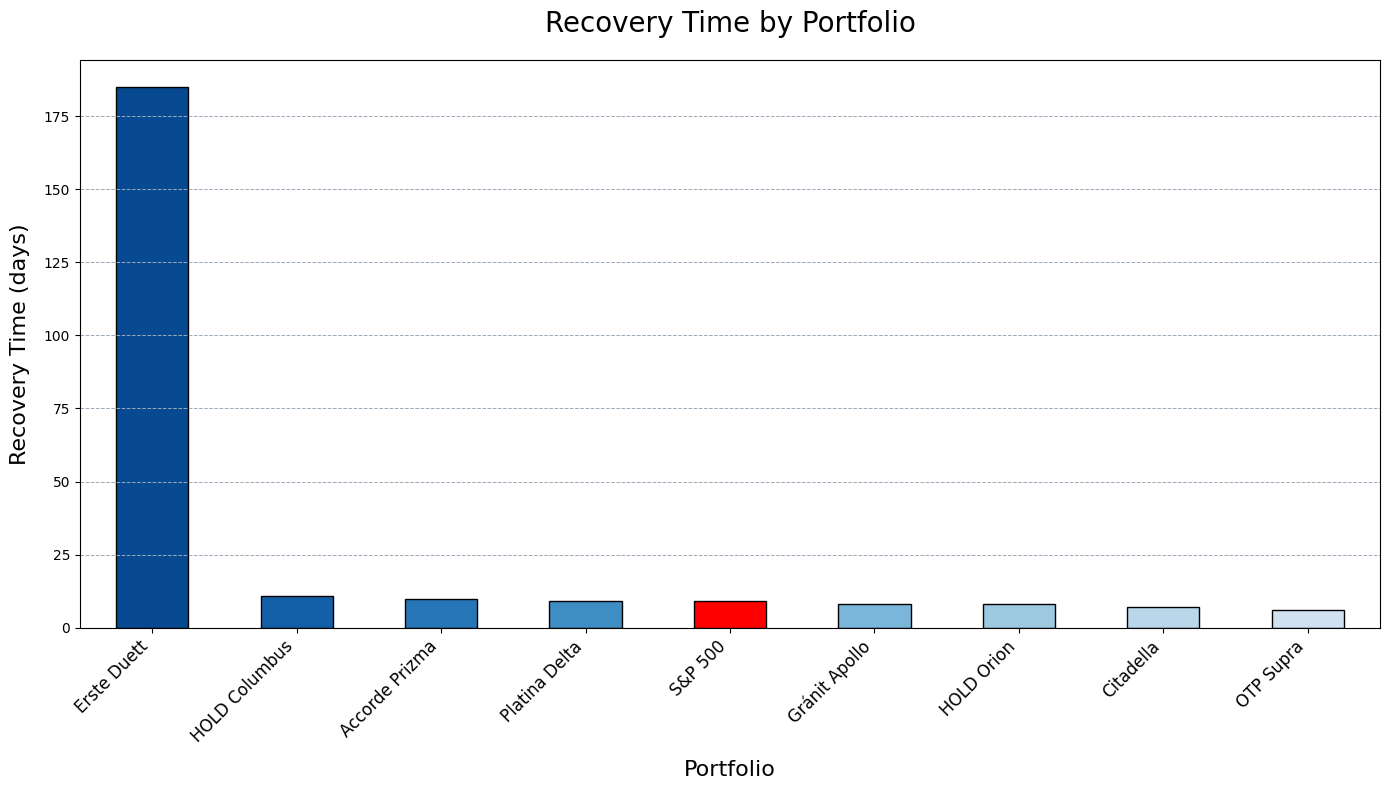

In [ ]:

def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown_value = drawdown.min()
    return max_drawdown_value

# Apply the Max Drawdown function to each portfolio
max_drawdowns = daily_returns.apply(max_drawdown)
print("Max Drawdowns:\n", max_drawdowns)

# 2. Calmar Ratio
def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown)

# Calculate the annualized return for each portfolio
annualized_returns = daily_returns.mean() * 252

# Apply the Calmar Ratio function to each portfolio
calmar_ratios = pd.Series({col: calmar_ratio(annualized_returns[col], max_drawdowns[col]) for col in daily_returns.columns})
print("Calmar Ratios:\n", calmar_ratios)

# 3. Recovery Time Analysis
def recovery_time(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    recovery_time = (drawdown == 0).astype(int).groupby(drawdown.ne(0).cumsum()).cumsum().max()
    return recovery_time

# Apply the Recovery Time function to each portfolio
recovery_times = daily_returns.apply(recovery_time)
print("Recovery Times:\n", recovery_times)

# Visualization
draw_decreasing_barchart(max_drawdowns, "Max Drawdown by Portfolio", "Portfolio", "Max Drawdown")
draw_decreasing_barchart(calmar_ratios, "Calmar Ratio by Portfolio", "Portfolio", "Calmar Ratio")
draw_decreasing_barchart(recovery_times, "Recovery Time by Portfolio", "Portfolio", "Recovery Time (days)")


30
Citadella 0.005114907085257701 0.00016905179065092364
HOLD Columbus 0.005233368158077329 0.00036109201056066587
HOLD Orion 0.006968672051946878 0.0004124682224638111
Platina Delta 0.008700583968420201 0.0006535851585319277
Accorde Prizma 0.002991245545761778 0.00017342688903253768
OTP Supra 0.008404562255684254 -0.00014728610624441105
Erste Duett 0.0005312277972793332 0.0001758847858958656
S&P 500 0.014630257125675577 0.0008348972739427364


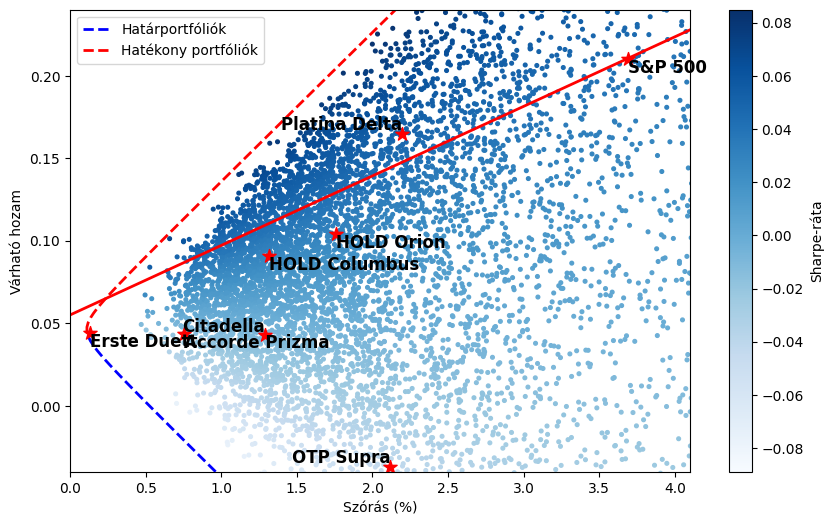

In [ ]:

def calculate_returns(data):
    return data.pct_change().dropna()

def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)*1000
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y,returns, tickers, interesting):
    plt.figure(figsize=(10, 6))
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    plt.colorbar(label='Sharpe-ráta')
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)
    for tick in tickers:
        # if tick == benchmark:
        #    continue
        print(tick, np.sqrt(returns[tick].var()),  returns[tick].mean())
        plt.scatter(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, color='red', marker='*', s=100, zorder=2, )
        if tick in interesting:
            if tick in ['Citadella', 'Accord Prizma', 'OTP Supra', 'Platina Delta']:
                plt.text(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, tick, fontsize=12, fontweight="bold", verticalalignment='bottom', horizontalalignment='right', color='black')

            else:
                plt.text(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, tick, fontsize=12, fontweight="bold", verticalalignment='top', horizontalalignment='left', color='black')
        
    sample2_volatility, sample2_return= np.sqrt(returns[benchmark].var())*252,returns[benchmark].mean()*252
    cal_x = np.linspace(min_x, max_x, 100)
    cal_y = risk_free_rate + (sample2_return - risk_free_rate) / sample2_volatility * cal_x
    plt.plot(cal_x, cal_y, color='red', linestyle='-', zorder=1, linewidth=2)
    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()
interesting = ['Citadella', 'HOLD Columbus', 'HOLD Orion', 'Platina Delta', 'Accorde Prizma', 'OTP Supra', 'Erste Duett', benchmark ]
num_portfolios=10000
min_x, max_x = 0, 4.1
min_y, max_y = -0.04, 0.24
tickers = interesting
returns = calculate_returns(df[interesting])
results = efficient_frontier(returns, num_portfolios, annual_risk_free_rate)
mu = returns.mean() * 252  
Sigma = returns.cov() * 252  
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    # print(w_star)
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)
market_weights = market_portfolio(mu, Sigma, annual_risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, annual_risk_free_rate, min_x, max_x, min_y, max_y, returns, tickers, interesting)

plt.show()


In [ ]:
mu

Citadella         0.042601
HOLD Columbus     0.090995
HOLD Orion        0.103942
Platina Delta     0.164703
Accorde Prizma    0.043704
OTP Supra        -0.037116
Erste Duett       0.044323
S&P 500           0.210394
dtype: float64